<a href="https://colab.research.google.com/github/sarjakpatel/SJSU/blob/main/CMPE%20258/Assignment%207/CMPE_258_Assignment7_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 258: Assignment 7 Part 2
Simple one to one RNNs

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

In [5]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


BiDirectional RNNs

In [7]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


In [8]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Setting the MNIST dataset

In [9]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 10s 5ms/step - loss: 0.9837 - accuracy: 0.6883 - val_loss: 0.5854 - val_accuracy: 0.8131


In [11]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=10
)

Epoch 1/10
938/938 [==============================] - 45s 47ms/step - loss: 0.4261 - accuracy: 0.8727 - val_loss: 0.6606 - val_accuracy: 0.7819
Epoch 2/10
938/938 [==============================] - 46s 49ms/step - loss: 0.2608 - accuracy: 0.9221 - val_loss: 0.2282 - val_accuracy: 0.9287
Epoch 3/10
938/938 [==============================] - 45s 48ms/step - loss: 0.1987 - accuracy: 0.9392 - val_loss: 0.2064 - val_accuracy: 0.9303
Epoch 4/10
938/938 [==============================] - 44s 47ms/step - loss: 0.1663 - accuracy: 0.9497 - val_loss: 0.1343 - val_accuracy: 0.9571
Epoch 5/10
938/938 [==============================] - 44s 46ms/step - loss: 0.1461 - accuracy: 0.9562 - val_loss: 0.1526 - val_accuracy: 0.9480
Epoch 6/10
938/938 [==============================] - 45s 47ms/step - loss: 0.1307 - accuracy: 0.9606 - val_loss: 0.1605 - val_accuracy: 0.9475
Epoch 7/10
938/938 [==============================] - 46s 49ms/step - loss: 0.1192 - accuracy: 0.9636 - val_loss: 0.1074 - val_accuracy:

Predicted result is: [3], target result is: 5


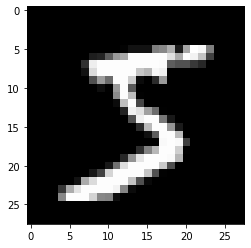

In [12]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

Here, the one to one RNN ends

#Many to one RNNs

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


Preparing the dataset

In [14]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [15]:
word_list =['<pad>'] + sorted(set(sum(sentences, []))) 
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)

['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [16]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

print(pos_list)
print(pos2idx)
print(idx2pos)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


In [17]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


In [19]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)

print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


Model implementation 

In [21]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, SimpleRNN

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, input_length=10,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed (TimeDistr  (None, 10, 8)            88        
 ibuted)                                                         
                                                                 
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [23]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [24]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_sequence=10)
        grads = tape.gradient(tr_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, avg_tr_loss))

Epoch:   5, tr_loss: 0.773
Epoch:  10, tr_loss: 0.383
Epoch:  15, tr_loss: 0.248
Epoch:  20, tr_loss: 0.095
Epoch:  25, tr_loss: 0.040
Epoch:  30, tr_loss: 0.015


Conclusion: The model is trained at 0.003 loss

In [25]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 3., 4., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

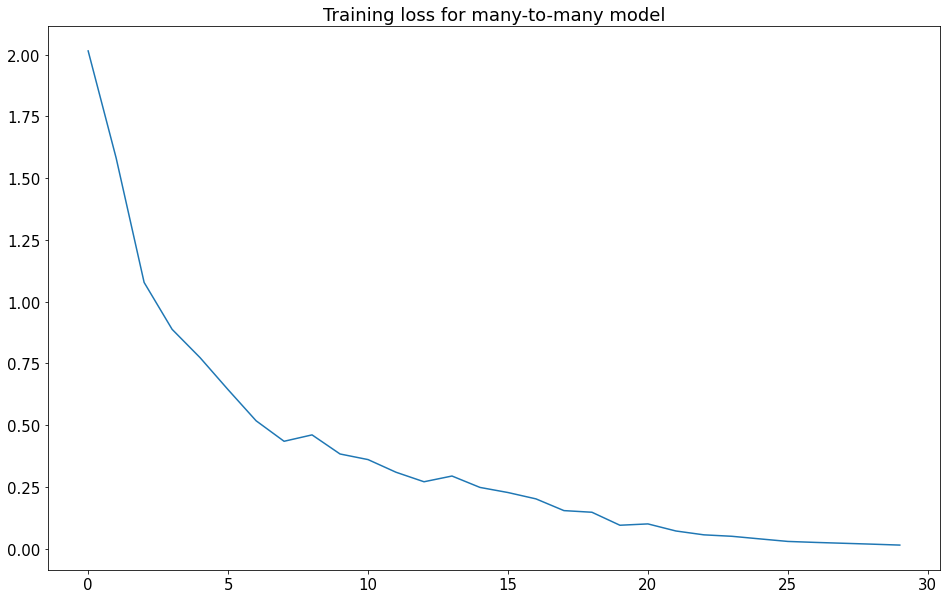

In [26]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many model')
plt.show()

Here, many to many RNNs end.

#Many to one RNNs

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


In [28]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

In [29]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

Let us have a look at out newly formed data

In [30]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [31]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

Vectorization of tokens

In [32]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [33]:
X

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]

In [34]:
X_len

[4, 3, 5, 7]

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

In [36]:
X

array([[ 6,  7,  7,  4,  0,  0,  0,  0,  0,  0],
       [ 3,  2,  4,  0,  0,  0,  0,  0,  0,  0],
       [10,  7,  8,  9,  5,  0,  0,  0,  0,  0],
       [ 9,  7,  1,  6,  7,  7,  4,  0,  0,  0]], dtype=int32)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                260       
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 507
Trainable params: 282
Non-trainable params: 225
_________________________________________________________________


In [38]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


After that, we can build many-to-one model with simpleRNN.

In [39]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [40]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [41]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.108213
epoch:  10, tr_loss: 0.008636
epoch:  15, tr_loss: 0.002620
epoch:  20, tr_loss: 0.001502
epoch:  25, tr_loss: 0.001120
epoch:  30, tr_loss: 0.000936


The many to one model is trained at 0.000724% loss at 30 Epochs

In [42]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [43]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))
# The accuracy for this model is close to 100%.

acc: 100.00%


The loss curve for Many to one is :


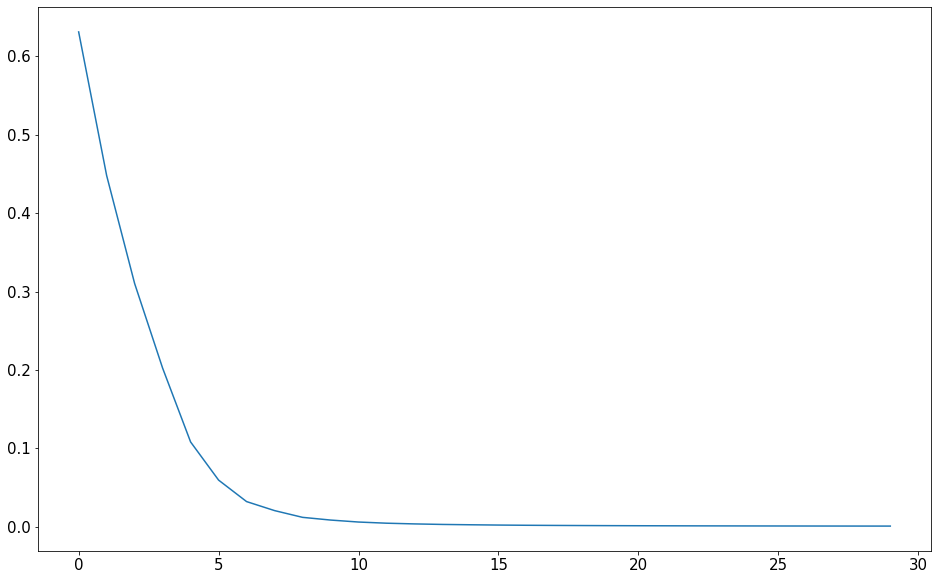

In [44]:
print("The loss curve for Many to one is :")
plt.figure()
plt.plot(tr_loss_hist)
plt.show()